# Importing libraries

In [1]:
import os
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2022-11-28 19:37:53.993885: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 19:37:54.109335: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-28 19:37:54.588506: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-28 19:37:54.588559: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

2.10.0


# Defining variables

In [2]:
dataset_dir = '../input/homework1/training_data_final'
submodels_dir = '../input/ann_homework1_ensemble'

In [3]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.compat.v1.set_random_seed(seed)

In [4]:
labels = ['Species1', # 1
          'Species2', # 2
          'Species3', # 3
          'Species4', # 4
          'Species5', # 5
          'Species6', # 6
          'Species7', # 7
          'Species8', # 8
]

In [5]:
image_size_2D = (96, 96)
input_shape = (96, 96, 3)
val_split = 0.2

epochs = 200
batch_size = 8
lr=1e-4

effnet_freeze = 0
dense_freeze = 0
convnext_freeze = 0

In [6]:
model_names = ['EfficientNet', 'DenseNet', 'ConvNeXt']

# Evaluation

### Performance

In [7]:
def evaluate_classes_performance(model, validation_dataset):

    data_list = []
    label_list = []
    batch_index = 0

    while batch_index <= validation_dataset.batch_index:
        data = validation_dataset.next()

        for i in range(len(data[0])):
            data_list.append(data[0][i])
            label_list.append(data[1][i])

        batch_index = batch_index + 1

    data_array = np.array(data_list)
    label_array = np.array(label_list)   
    label_values = np.argmax(label_array, axis=1)
    predictions = model.predict(data_array)
    predictions = np.argmax(predictions, axis=1)
    
    report = classification_report(label_values, predictions)
    print(report)

### Plots

In [8]:
def plot_acc_loss(history):
    plt.figure(figsize=(20,5))
    plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
    plt.legend(loc='upper left')
    plt.title('Binary Crossentropy')
    plt.grid(alpha=.3)

    plt.figure(figsize=(20,5))
    plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
    plt.legend(loc='upper left')
    plt.title('Accuracy')
    plt.grid(alpha=.3)

    plt.show()

In [9]:
def plot_double_acc_loss(history1, history2):
   plt.figure(figsize=(15,5))
   plt.plot(history1['loss'], label='Training 1', alpha=.3, color='#4D61E2', linestyle='--')
   plt.plot(history1['val_loss'], label='Validation 1', alpha=.8, color='#4D61E2')
   plt.plot(history2['loss'],  label='Training 2', alpha=.3, color='#2ABC3D', linestyle='--')
   plt.plot(history2['val_loss'], label='Validation 2', alpha=.8, color='#2ABC3D')
   plt.legend(loc='upper left')
   plt.title('Categorical Crossentropy')
   plt.grid(alpha=.3)
   plt.figure(figsize=(15,5))
   plt.plot(history1['accuracy'], label='Training 1', alpha=.3, color='#4D61E2', linestyle='--')
   plt.plot(history1['val_accuracy'], label='Validation 1', alpha=.8, color='#4D61E2')
   plt.plot(history2['accuracy'], label='Training 2', alpha=.3, color='#2ABC3D', linestyle='--')
   plt.plot(history2['val_accuracy'], label='Validation 2', alpha=.8, color='#2ABC3D')
   plt.legend(loc='upper left')
   plt.title('Accuracy')
   plt.grid(alpha=.3)
   plt.show()

# Importing the dataset

In [10]:
# Augmented ImageDataGenerator
aug_train_data_gen = ImageDataGenerator(rotation_range=40, 
                                        fill_mode='reflect',
                                        height_shift_range=40,
                                        width_shift_range=30,
                                        brightness_range=[0.5,1.3],
                                        zoom_range=0.5,
                                        vertical_flip=True,
                                        horizontal_flip=True,
                                        validation_split=val_split
                                       )
# Non-augmented ImageDataGenerator
no_aug_data_gen = ImageDataGenerator(validation_split=val_split)

In [11]:
# Load training data (augmented and non-augmented) and validation data
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=image_size_2D,
                                               color_mode='rgb',
                                               classes=labels,
                                               subset="training",
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=True,
                                               seed=seed)
train_gen = no_aug_data_gen.flow_from_directory(directory=dataset_dir,
                                                target_size=image_size_2D,
                                                color_mode='rgb',
                                                classes=labels,
                                                subset="training",
                                                class_mode='categorical',
                                                batch_size=batch_size,
                                                shuffle=True,
                                                seed=seed)
valid_gen = no_aug_data_gen.flow_from_directory(directory=dataset_dir,
                                                target_size=image_size_2D,
                                                color_mode='rgb',
                                                classes=labels,
                                                subset="validation",
                                                class_mode='categorical',
                                                batch_size=batch_size,
                                                shuffle=False,
                                                seed=seed)

Found 2836 images belonging to 8 classes.
Found 2836 images belonging to 8 classes.
Found 706 images belonging to 8 classes.


## General model construction

### Model building

In [12]:
def compile_model(model, learning_rate):
    model.compile(
        loss=tfk.losses.CategoricalCrossentropy(),
        optimizer=tfk.optimizers.Adam(learning_rate),
        metrics='accuracy'
    )
    return model

In [13]:
def build_classifier_on_top(supernet, preprocessing_layer, name='model'):
    # Input layer
    inputs = tfk.Input(shape=input_shape, name='input')
    # Preprocessing layer
    x = preprocessing_layer(inputs)
    # Supernet 
    x = supernet(x)
    # GAP layer
    x = tfkl.GlobalAveragePooling2D(name='GAP')(x)
    # First hidden block
    x = tfkl.Dropout(0.3, name='dropout_1', seed=seed)(x)
    x = tfkl.Dense(
        256, 
        activation='relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name='dense_1',
    )(x)
    # Second hidden block
    x = tfkl.Dropout(0.3, name='dropout_2',seed=seed)(x)
    x = tfkl.Dense(
        256, 
        activation='relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name='dense_2',
    )(x)
    # Output block
    x = tfkl.Dropout(0.3, name='dropout_3',seed=seed)(x)
    outputs = tfkl.Dense(
        8, 
        activation='softmax',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name='output',
    )(x)
    # Create and compile full model
    model = tfk.Model(inputs=inputs, outputs=outputs, name=name)
    model = compile_model(model, lr)
    
    return model

In [14]:
def build_model(base_net, freeze_count, preprocessing_layer, name):
    # Import base net model
    model_supernet = base_net(
        include_top=False, # Do not include classifier
        weights="imagenet",
        input_shape=input_shape
    )

    # Set all the layers of the base net as trainable
    model_supernet.trainable = True
    
    # Freeze layers
    for i, layer in enumerate(model_supernet.layers[:freeze_count]):
        layer.trainable=False
        
    # Attach new classifier to base net
    model = build_classifier_on_top(
        model_supernet,
        preprocessing_layer,
        name=name,
    )
    
    return model

### Callbacks

In [15]:
def define_callbacks():
    callbacks = []
    # Early stopping callback
    es_callback = tfk.callbacks.EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=10,
        restore_best_weights=True,
    )
    callbacks.append(es_callback)
    # Other callbacks ...
    return callbacks

# EfficientNet Model

### Model creation

In [16]:
effnet_model = build_model(
    tfk.applications.EfficientNetB7,
    effnet_freeze,
    tfk.applications.efficientnet.preprocess_input,
    'effnet_model',
)

2022-11-28 19:37:58.018590: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 19:37:58.030724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 19:37:58.031053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-28 19:37:58.031580: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [17]:
effnet_model.summary()

Model: "effnet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetb7 (Functional)  (None, 3, 3, 2560)       64097687  
                                                                 
 GAP (GlobalAveragePooling2D  (None, 2560)             0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 2560)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               655616    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                      

### First training

In [18]:
# Fine tune the model
effnet_history_1 = effnet_model.fit(
    x = aug_train_gen,
    validation_data = valid_gen,
    epochs = epochs,
    callbacks = define_callbacks(),
).history

Epoch 1/200


2022-11-28 19:38:25.085690: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2022-11-28 19:38:25.871680: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.22GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-28 19:38:25.881694: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-28 19:38:25.944508: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains

355/355 [==============================] - 146s 349ms/step - loss: 1.8643 - accuracy: 0.2750 - val_loss: 1.4172 - val_accuracy: 0.4986
Epoch 2/200
355/355 [==============================] - 117s 329ms/step - loss: 1.4668 - accuracy: 0.4580 - val_loss: 1.1387 - val_accuracy: 0.6176
Epoch 3/200
355/355 [==============================] - 119s 336ms/step - loss: 1.2961 - accuracy: 0.5339 - val_loss: 1.0266 - val_accuracy: 0.6516
Epoch 4/200
355/355 [==============================] - 119s 336ms/step - loss: 1.2222 - accuracy: 0.5797 - val_loss: 0.8550 - val_accuracy: 0.7139
Epoch 5/200
355/355 [==============================] - 125s 351ms/step - loss: 1.1331 - accuracy: 0.6012 - val_loss: 0.7255 - val_accuracy: 0.7550
Epoch 6/200
355/355 [==============================] - 117s 330ms/step - loss: 1.0603 - accuracy: 0.6435 - val_loss: 0.7666 - val_accuracy: 0.7351
Epoch 7/200
355/355 [==============================] - 119s 336ms/step - loss: 1.0052 - accuracy: 0.6523 - val_loss: 0.6529 - val_

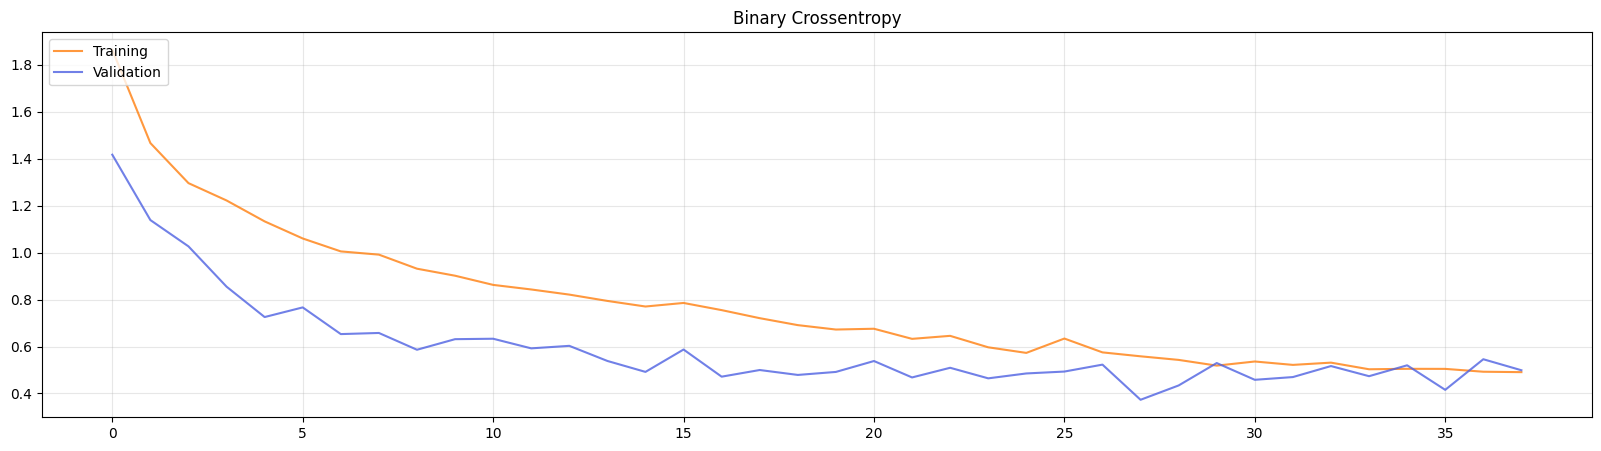

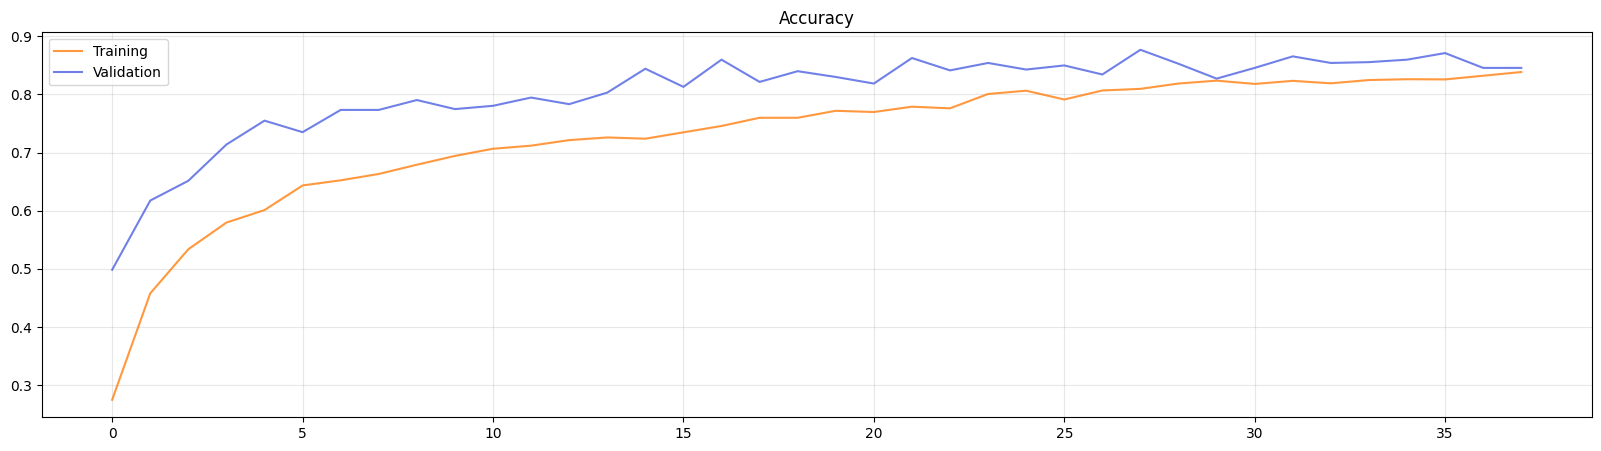

In [19]:
# Plot training history
plot_acc_loss(effnet_history_1)

### Model editing

In [20]:
# Use the supernet with the fine-tuned weights only as feature extractor
effnet_model.get_layer('efficientnetb7').trainable = False

# Recompile the model
effnet_model = compile_model(effnet_model, lr)

effnet_model.summary()

Model: "effnet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetb7 (Functional)  (None, 3, 3, 2560)       64097687  
                                                                 
 GAP (GlobalAveragePooling2D  (None, 2560)             0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 2560)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               655616    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                      

### Second training

In [21]:
# Train the classifier on non-augmented training data
effnet_history_2 = effnet_model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = define_callbacks(),
).history

Epoch 1/200
355/355 [==============================] - 37s 74ms/step - loss: 0.2006 - accuracy: 0.9305 - val_loss: 0.3311 - val_accuracy: 0.8966
Epoch 2/200
355/355 [==============================] - 23s 64ms/step - loss: 0.1708 - accuracy: 0.9411 - val_loss: 0.3370 - val_accuracy: 0.8909
Epoch 3/200
355/355 [==============================] - 23s 64ms/step - loss: 0.1574 - accuracy: 0.9432 - val_loss: 0.3288 - val_accuracy: 0.8924
Epoch 4/200
355/355 [==============================] - 22s 63ms/step - loss: 0.1422 - accuracy: 0.9503 - val_loss: 0.3305 - val_accuracy: 0.8924
Epoch 5/200
355/355 [==============================] - 22s 63ms/step - loss: 0.1351 - accuracy: 0.9538 - val_loss: 0.3353 - val_accuracy: 0.8924
Epoch 6/200
355/355 [==============================] - 23s 64ms/step - loss: 0.1212 - accuracy: 0.9577 - val_loss: 0.3352 - val_accuracy: 0.8966
Epoch 7/200
355/355 [==============================] - 23s 64ms/step - loss: 0.1127 - accuracy: 0.9602 - val_loss: 0.3442 - val_ac

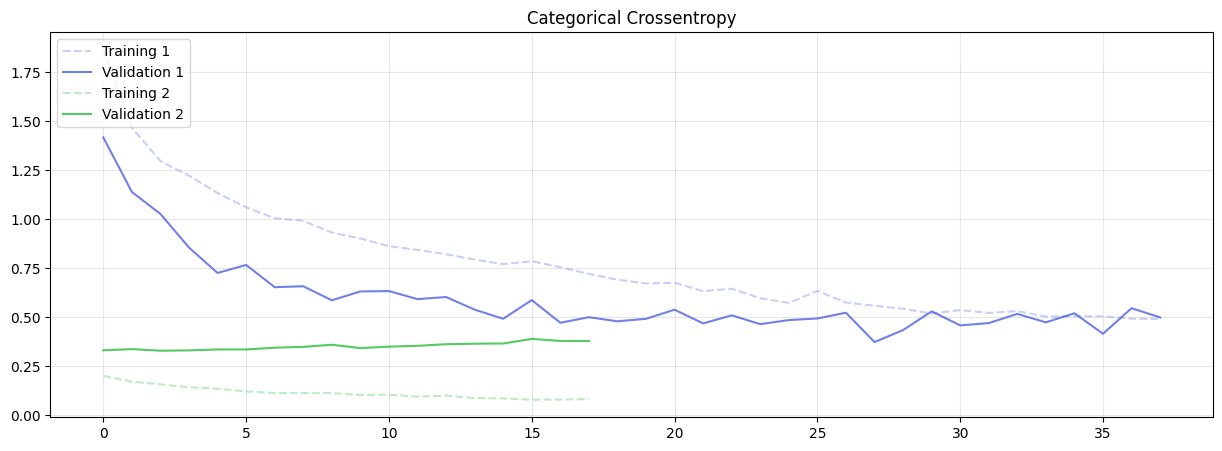

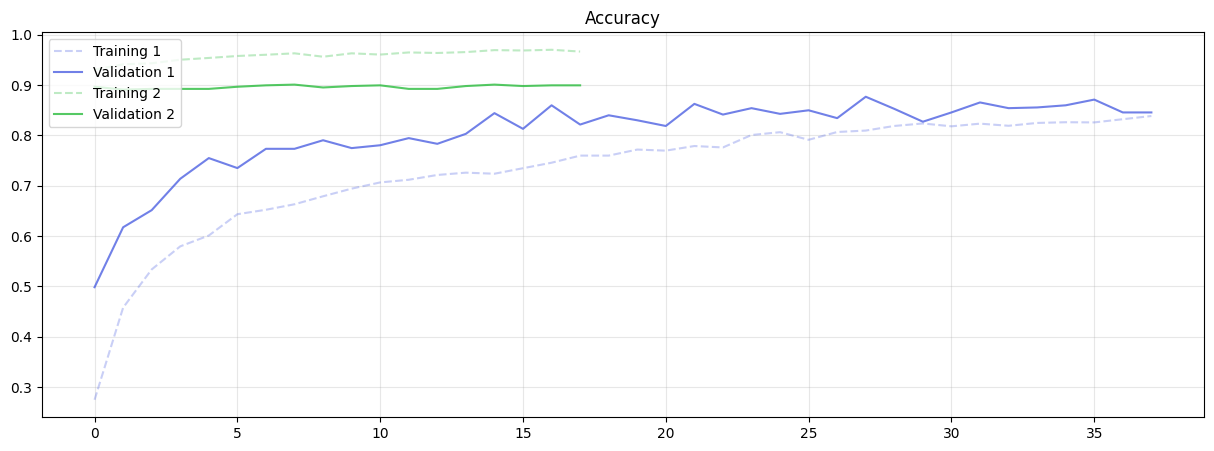

In [22]:
# Plot training history
plot_double_acc_loss(effnet_history_1, effnet_history_2)

### Performance

In [23]:
# Evaluate the performance scores for the model on the validation dataset 
evaluate_classes_performance(effnet_model, valid_gen)

23/23 [==============================] - 6s 119ms/step
              precision    recall  f1-score   support

           0       0.66      0.68      0.67        37
           1       0.93      0.89      0.91       106
           2       0.93      0.96      0.95       103
           3       0.91      0.91      0.91       102
           4       0.91      0.92      0.91       106
           5       0.97      0.84      0.90        44
           6       0.95      0.98      0.97       107
           7       0.83      0.85      0.84       101

    accuracy                           0.90       706
   macro avg       0.89      0.88      0.88       706
weighted avg       0.90      0.90      0.90       706



### Save

In [ ]:
effnet_model.save('EfficientNet')

# DenseNet Model

### Model creation

In [25]:
dense_model = build_model(
    tfk.applications.DenseNet201,
    dense_freeze,
    tfk.applications.densenet.preprocess_input,
    'densenet_model',
)

In [26]:
dense_model.summary()

Model: "densenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 96, 96, 3)        0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 96, 96, 3)        0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 96, 96, 3)        0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (None, 3, 3, 1920)        18321984  
                                                                 
 GAP (GlobalAveragePooling2D  (None, 1920)          

### First training

In [27]:
# Fine tune the model
dense_history_1 = dense_model.fit(
    x = aug_train_gen,
    validation_data = valid_gen,
    epochs = epochs,
    callbacks = define_callbacks(),
).history

Epoch 1/200
355/355 [==============================] - 57s 120ms/step - loss: 2.0055 - accuracy: 0.2888 - val_loss: 1.4685 - val_accuracy: 0.4348
Epoch 2/200
355/355 [==============================] - 37s 105ms/step - loss: 1.5515 - accuracy: 0.4358 - val_loss: 1.0311 - val_accuracy: 0.6147
Epoch 3/200
355/355 [==============================] - 37s 104ms/step - loss: 1.3865 - accuracy: 0.4979 - val_loss: 1.2337 - val_accuracy: 0.5992
Epoch 4/200
355/355 [==============================] - 37s 105ms/step - loss: 1.2795 - accuracy: 0.5536 - val_loss: 0.9865 - val_accuracy: 0.6516
Epoch 5/200
355/355 [==============================] - 37s 105ms/step - loss: 1.2181 - accuracy: 0.5804 - val_loss: 0.7021 - val_accuracy: 0.7790
Epoch 6/200
355/355 [==============================] - 37s 104ms/step - loss: 1.1714 - accuracy: 0.5899 - val_loss: 0.8128 - val_accuracy: 0.7521
Epoch 7/200
355/355 [==============================] - 37s 104ms/step - loss: 1.0918 - accuracy: 0.6266 - val_loss: 0.8025 -

Epoch 57/200
355/355 [==============================] - 37s 104ms/step - loss: 0.5453 - accuracy: 0.8163 - val_loss: 0.4844 - val_accuracy: 0.8371
Epoch 58/200
355/355 [==============================] - 37s 105ms/step - loss: 0.5140 - accuracy: 0.8269 - val_loss: 0.7967 - val_accuracy: 0.7663
Epoch 59/200
355/355 [==============================] - 37s 105ms/step - loss: 0.5542 - accuracy: 0.8230 - val_loss: 0.4217 - val_accuracy: 0.8739
Epoch 60/200
355/355 [==============================] - 37s 105ms/step - loss: 0.5164 - accuracy: 0.8209 - val_loss: 0.6272 - val_accuracy: 0.8385


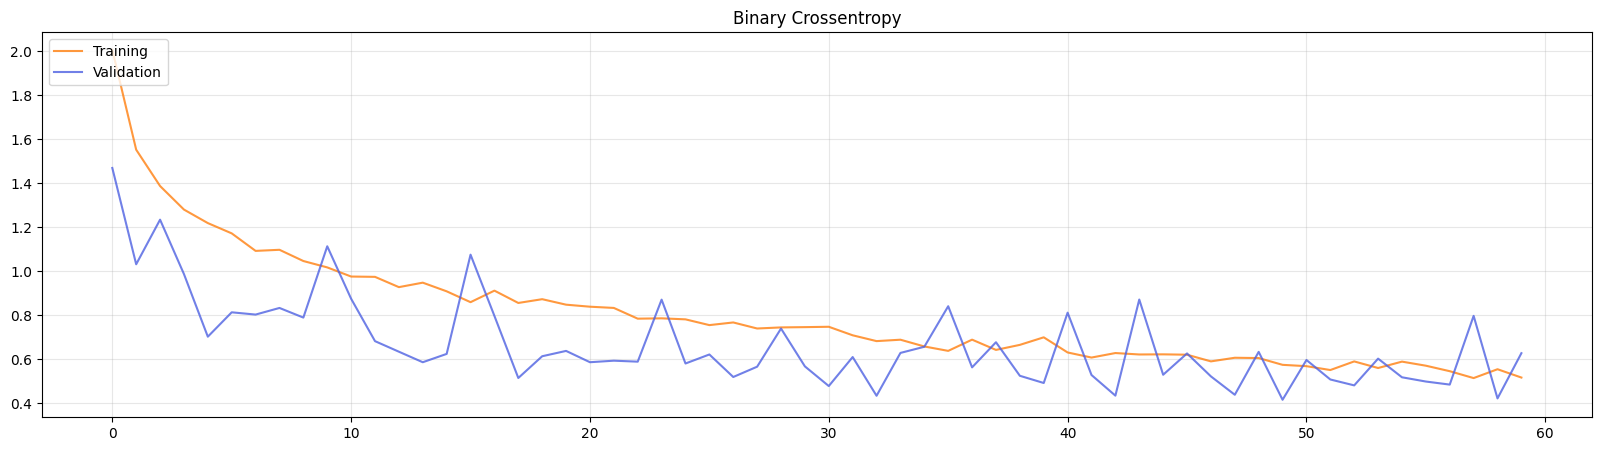

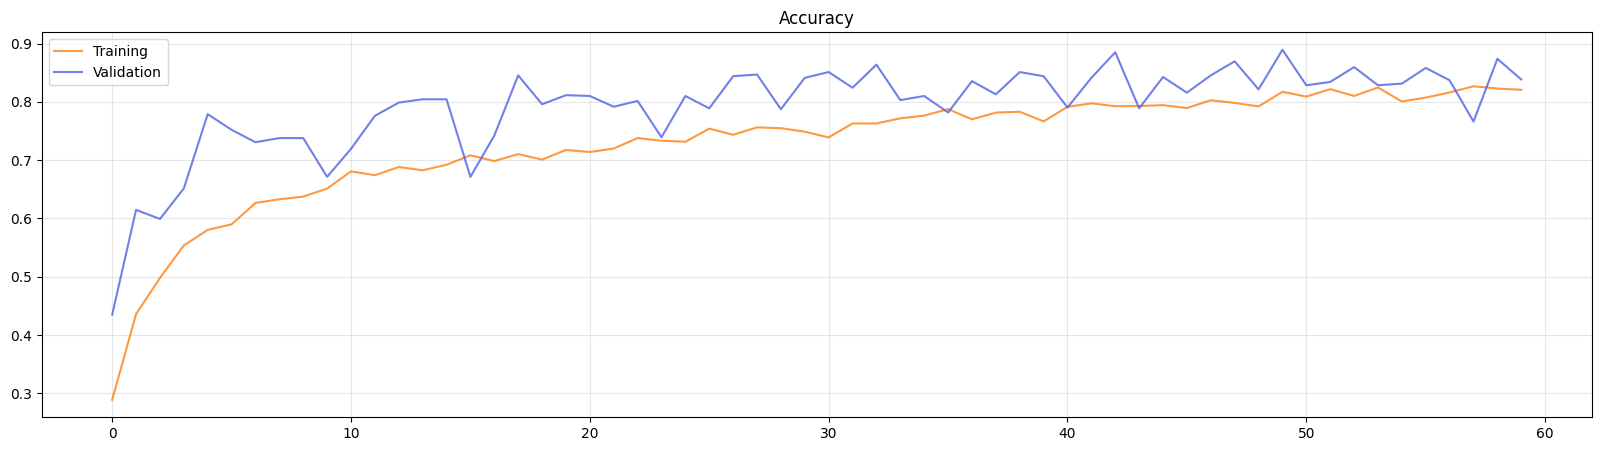

In [28]:
# Plot training history
plot_acc_loss(dense_history_1)

### Model editing

In [29]:
# Use the supernet with the fine-tuned weights only as feature extractor
dense_model.get_layer('densenet201').trainable = False

# Recompile the model
dense_model = compile_model(dense_model, lr)

dense_model.summary()

Model: "densenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 96, 96, 3)        0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 96, 96, 3)        0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 96, 96, 3)        0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (None, 3, 3, 1920)        18321984  
                                                                 
 GAP (GlobalAveragePooling2D  (None, 1920)          

### Second training

In [30]:
# Train the classifier on non-augmented training data
dense_history_2 = dense_model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = define_callbacks(),
).history

Epoch 1/200
355/355 [==============================] - 20s 42ms/step - loss: 0.1851 - accuracy: 0.9369 - val_loss: 0.3653 - val_accuracy: 0.9037
Epoch 2/200
355/355 [==============================] - 13s 36ms/step - loss: 0.1575 - accuracy: 0.9499 - val_loss: 0.3593 - val_accuracy: 0.9108
Epoch 3/200
355/355 [==============================] - 13s 36ms/step - loss: 0.1442 - accuracy: 0.9528 - val_loss: 0.3556 - val_accuracy: 0.9051
Epoch 4/200
355/355 [==============================] - 13s 36ms/step - loss: 0.1438 - accuracy: 0.9489 - val_loss: 0.3592 - val_accuracy: 0.9023
Epoch 5/200
355/355 [==============================] - 13s 35ms/step - loss: 0.1401 - accuracy: 0.9478 - val_loss: 0.3673 - val_accuracy: 0.9008
Epoch 6/200
355/355 [==============================] - 13s 36ms/step - loss: 0.1292 - accuracy: 0.9594 - val_loss: 0.3596 - val_accuracy: 0.8994
Epoch 7/200
355/355 [==============================] - 13s 36ms/step - loss: 0.1189 - accuracy: 0.9580 - val_loss: 0.3690 - val_ac

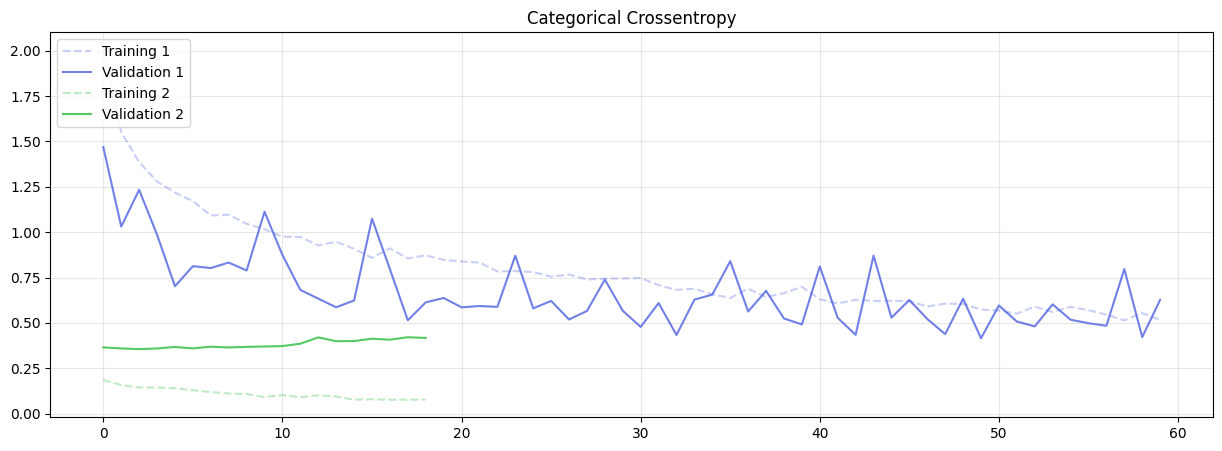

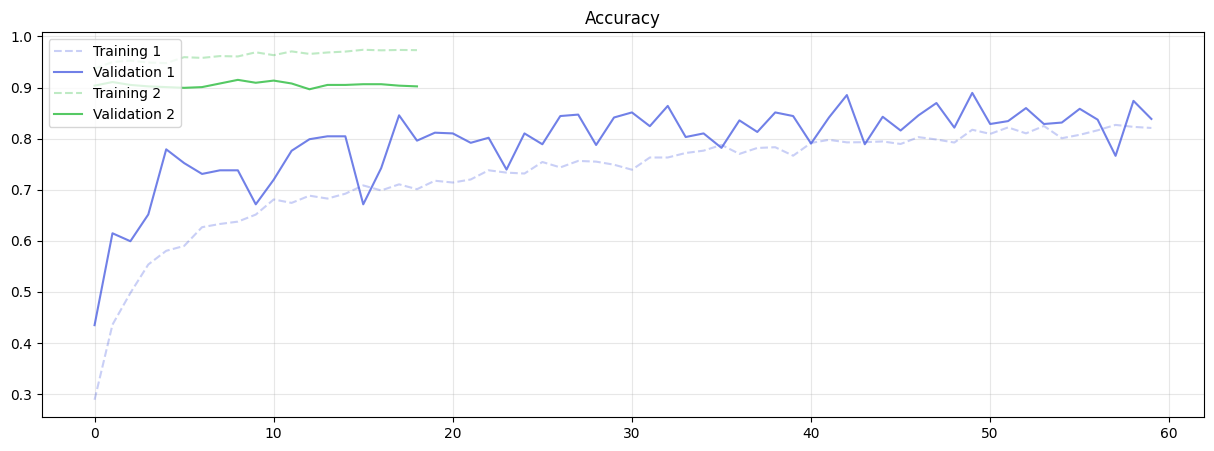

In [31]:
# Plot training history
plot_double_acc_loss(dense_history_1, dense_history_2)

### Performance

In [32]:
# Evaluate the performance scores for the model on the validation dataset 
evaluate_classes_performance(dense_model, valid_gen)

23/23 [==============================] - 6s 45ms/step
              precision    recall  f1-score   support

           0       0.62      0.70      0.66        37
           1       0.96      0.93      0.95       106
           2       0.92      0.95      0.94       103
           3       0.91      0.93      0.92       102
           4       0.92      0.92      0.92       106
           5       0.98      0.91      0.94        44
           6       0.96      1.00      0.98       107
           7       0.89      0.83      0.86       101

    accuracy                           0.92       706
   macro avg       0.90      0.90      0.90       706
weighted avg       0.92      0.92      0.92       706



### Save

In [33]:
dense_model.save('DenseNet')

INFO:tensorflow:Assets written to: DenseNet/assets


INFO:tensorflow:Assets written to: DenseNet/assets


# ConvNeXt Model

### Model building

In [34]:
convnext_model = build_model(
    tfk.applications.ConvNeXtTiny,
    convnext_freeze,
    tfk.applications.convnext.preprocess_input,
    'convnext_model',
)

In [35]:
convnext_model.summary()

Model: "convnext_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_tiny (Functional)  (None, 3, 3, 768)         27820128  
                                                                 
 GAP (GlobalAveragePooling2D  (None, 768)              0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 768)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               196864    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                    

### First training

In [36]:
# Fine tune the model
convnext_history_1 = convnext_model.fit(
    x = aug_train_gen,
    validation_data = valid_gen,
    epochs = epochs,
    callbacks = define_callbacks(),
).history

Epoch 1/200


2022-11-28 21:56:06.040965: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x19f3f570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-28 21:56:06.041014: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2022-11-28 21:56:06.270726: W tensorflow/compiler/xla/service/gpu/nvptx_helper.cc:56] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-11.2
  /usr/local/cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment variable XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda will work.
2022-11-28 21:56:06.362453: I tensorflow/compiler/jit/xla_compilation_cache.cc:4

355/355 [==============================] - 44s 97ms/step - loss: 1.9808 - accuracy: 0.3177 - val_loss: 1.3074 - val_accuracy: 0.4603
Epoch 2/200
355/355 [==============================] - 30s 84ms/step - loss: 1.2686 - accuracy: 0.5462 - val_loss: 0.9895 - val_accuracy: 0.6346
Epoch 3/200
355/355 [==============================] - 30s 84ms/step - loss: 1.0537 - accuracy: 0.6453 - val_loss: 0.7254 - val_accuracy: 0.7436
Epoch 4/200
355/355 [==============================] - 30s 84ms/step - loss: 0.8589 - accuracy: 0.7084 - val_loss: 0.6185 - val_accuracy: 0.7720
Epoch 5/200
355/355 [==============================] - 30s 84ms/step - loss: 0.7563 - accuracy: 0.7609 - val_loss: 0.6676 - val_accuracy: 0.7833
Epoch 6/200
355/355 [==============================] - 30s 83ms/step - loss: 0.6588 - accuracy: 0.7867 - val_loss: 0.6041 - val_accuracy: 0.8031
Epoch 7/200
355/355 [==============================] - 30s 83ms/step - loss: 0.6232 - accuracy: 0.8004 - val_loss: 0.6285 - val_accuracy: 0.79

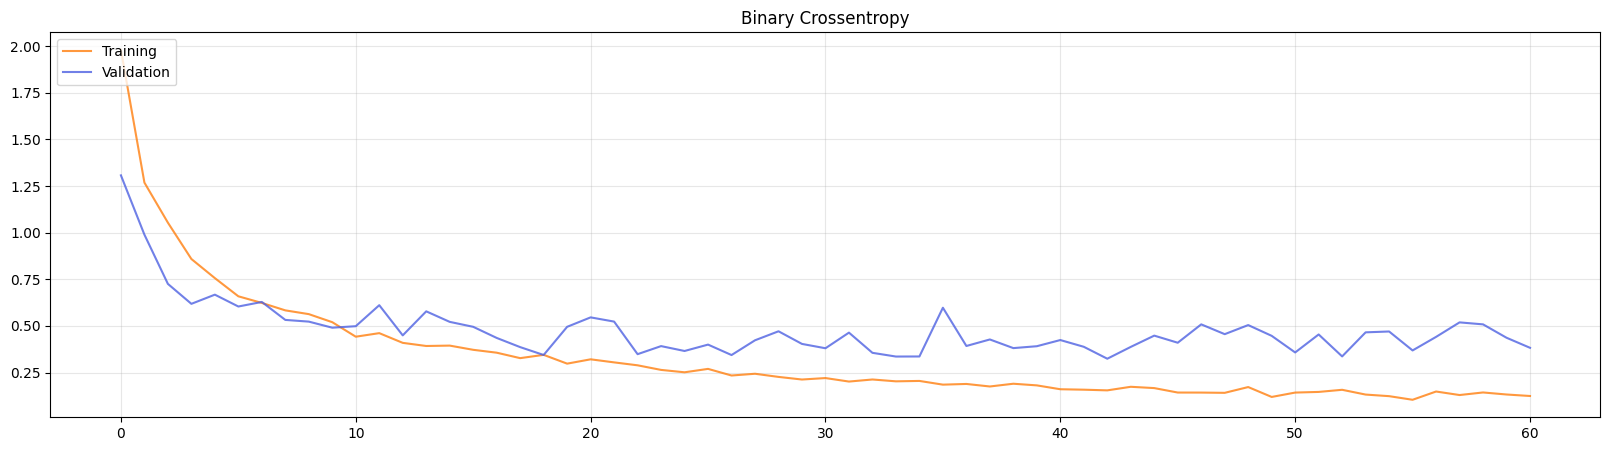

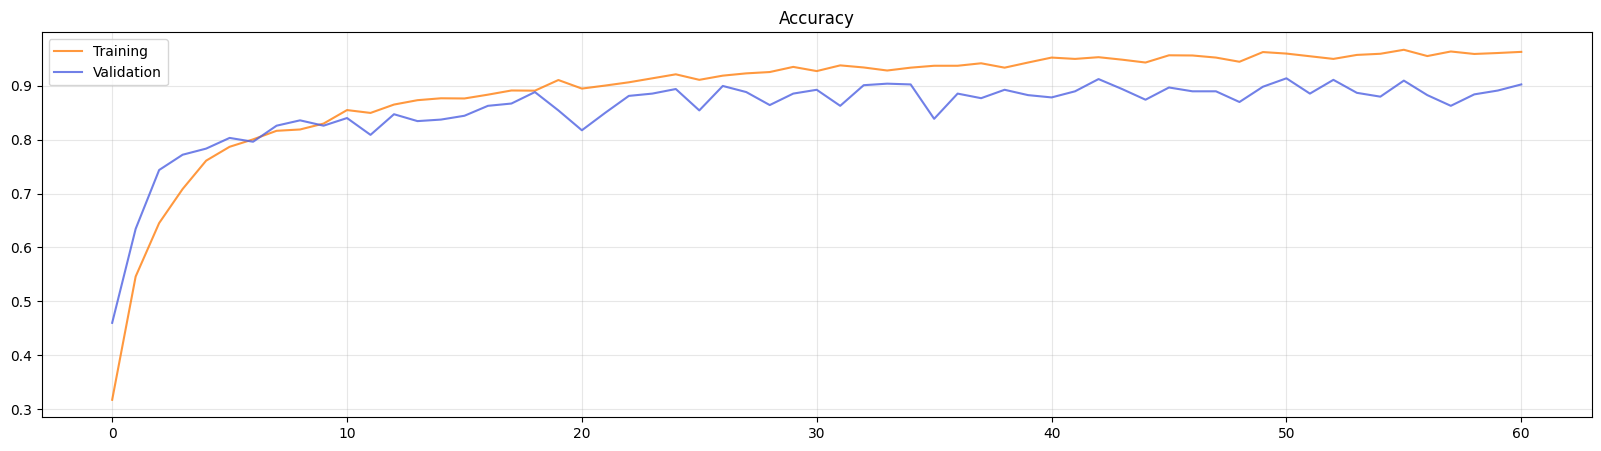

In [37]:
# Plot training history
plot_acc_loss(convnext_history_1)

### Model editing

In [38]:
# Use the supernet with the fine-tuned weights only as feature extractor
convnext_model.get_layer('convnext_tiny').trainable = False

# Recompile the model
convnext_model = compile_model(convnext_model, lr)

convnext_model.summary()

Model: "convnext_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_tiny (Functional)  (None, 3, 3, 768)         27820128  
                                                                 
 GAP (GlobalAveragePooling2D  (None, 768)              0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 768)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               196864    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                    

### Second training

In [39]:
# Train the classifier on non-augmented training data
convnext_history_2 = convnext_model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = define_callbacks(),
).history

Epoch 1/200
355/355 [==============================] - 19s 41ms/step - loss: 0.0244 - accuracy: 0.9922 - val_loss: 0.3926 - val_accuracy: 0.9178
Epoch 2/200
355/355 [==============================] - 13s 36ms/step - loss: 0.0177 - accuracy: 0.9951 - val_loss: 0.4042 - val_accuracy: 0.9207
Epoch 3/200
355/355 [==============================] - 12s 35ms/step - loss: 0.0143 - accuracy: 0.9958 - val_loss: 0.4106 - val_accuracy: 0.9207
Epoch 4/200
355/355 [==============================] - 12s 35ms/step - loss: 0.0102 - accuracy: 0.9961 - val_loss: 0.4230 - val_accuracy: 0.9278
Epoch 5/200
355/355 [==============================] - 13s 36ms/step - loss: 0.0088 - accuracy: 0.9968 - val_loss: 0.4380 - val_accuracy: 0.9263
Epoch 6/200
355/355 [==============================] - 13s 36ms/step - loss: 0.0053 - accuracy: 0.9986 - val_loss: 0.4552 - val_accuracy: 0.9249
Epoch 7/200
355/355 [==============================] - 13s 36ms/step - loss: 0.0060 - accuracy: 0.9979 - val_loss: 0.4720 - val_ac

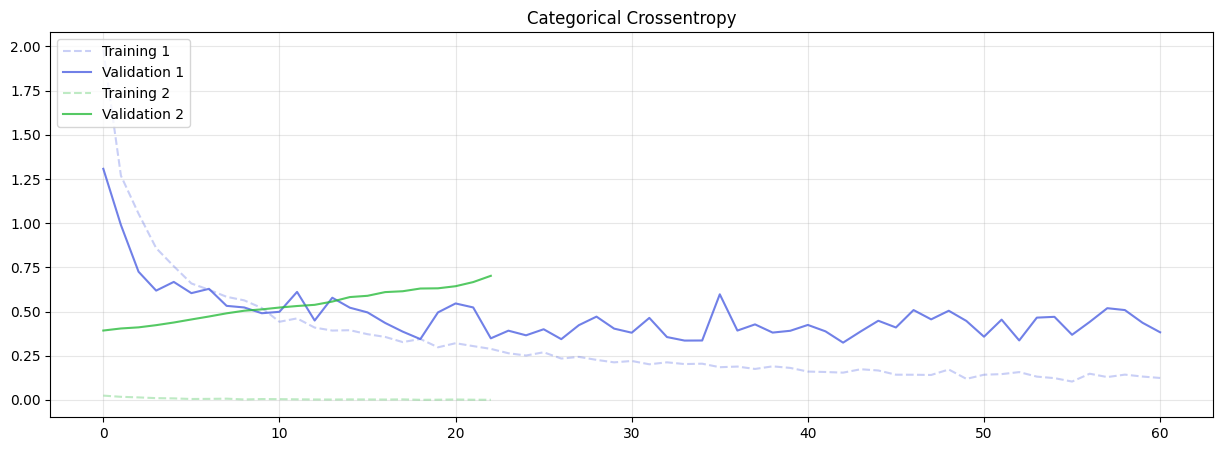

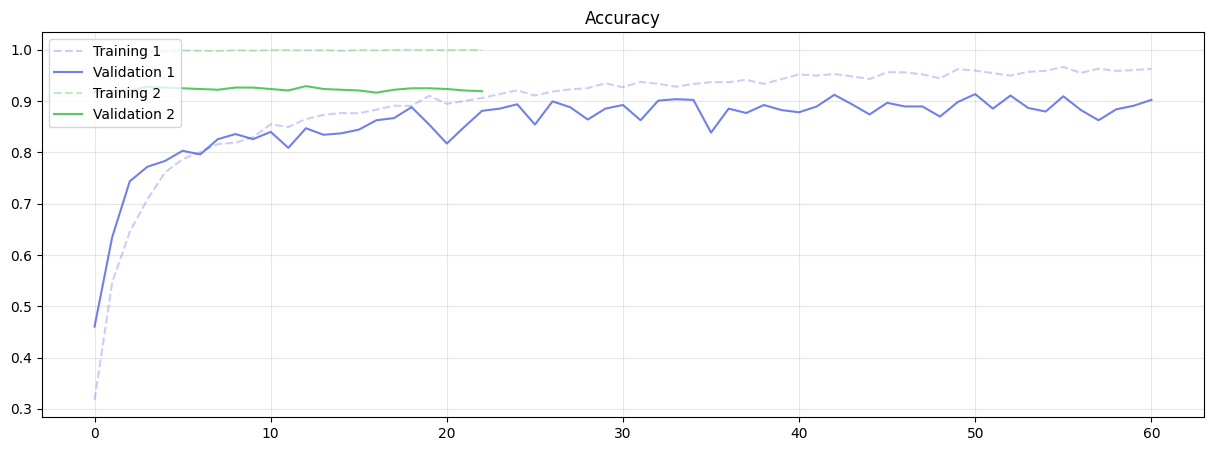

In [40]:
# Plot training history
plot_double_acc_loss(convnext_history_1, convnext_history_2)

### Performance

In [41]:
# Evaluate the performance scores for the model on the validation dataset 
evaluate_classes_performance(convnext_model, valid_gen)

23/23 [==============================] - 4s 73ms/step
              precision    recall  f1-score   support

           0       0.87      0.70      0.78        37
           1       0.89      0.96      0.92       106
           2       0.95      0.98      0.97       103
           3       0.93      0.90      0.92       102
           4       0.93      0.94      0.93       106
           5       0.93      0.84      0.88        44
           6       0.99      0.97      0.98       107
           7       0.91      0.93      0.92       101

    accuracy                           0.93       706
   macro avg       0.92      0.90      0.91       706
weighted avg       0.93      0.93      0.93       706



### Save

In [42]:
convnext_model.save('ConvNeXt')

INFO:tensorflow:Assets written to: ConvNeXt/assets


INFO:tensorflow:Assets written to: ConvNeXt/assets


# Ensemble Model

### Loading the submodels

In [43]:
def load_all_models(model_names):
    all_models = []
    for model_name in model_names:
        filename = os.path.join(submodels_dir, model_name)
        model = tfk.models.load_model(filename)
        all_models.append(model)
        print('Successfully loaded submodule:', filename)
        evaluate_classes_performance(model, valid_gen)
    return all_models

In [44]:
# Loading the submodels from existing saves
#submodels = load_all_models(model_names)

# Loading the submodels from in-notebook trained models
submodels = [effnet_model, dense_model, convnext_model]

In [45]:
# Standardize model names and make them non-trainable
for i, model in enumerate(submodels):
    model._name = f"model_{i}"
    for layer in model.layers:
        layer.trainable = False

### Build ensemble model

In [46]:
# Common input layer
input_layer = tfk.Input(shape=input_shape)
# Disaggregated submodel outputs
submodel_outputs = [model(input_layer) for model in submodels]
# Aggregate submodel outputs by concatenation
x = tfkl.concatenate(submodel_outputs)
# Hidden layer
x = tfkl.Dense(
    10, 
    activation='relu',
    kernel_initializer = tfk.initializers.HeUniform(seed),
    name='hidden_dense',
)(x)
# Output layer
ensemble_output = tfkl.Dense(
    8, 
    activation='softmax', 
    kernel_initializer = tfk.initializers.GlorotUniform(seed),
    name='ensemble_output',
)(x)
# Create and compile ensemble model
ens_model = tfk.Model(inputs=input_layer, outputs=ensemble_output, name='ens_model')
ens_model = compile_model(ens_model, learning_rate=1e-3)

In [47]:
ens_model.summary()

Model: "ens_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 model_0 (Functional)           (None, 8)            64821151    ['input_4[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 8)            18881608    ['input_4[0][0]']                
                                                                                                  
 model_2 (Functional)           (None, 8)            28084840    ['input_4[0][0]']                
                                                                                          

### Ensemble training

In [48]:
ens_history = ens_model.fit(
    x=aug_train_gen,
    epochs=epochs, 
    validation_data=valid_gen,
    callbacks = define_callbacks(),
).history

Epoch 1/200
355/355 [==============================] - 79s 158ms/step - loss: 1.5729 - accuracy: 0.5465 - val_loss: 0.9469 - val_accuracy: 0.8895
Epoch 2/200
355/355 [==============================] - 48s 136ms/step - loss: 0.5691 - accuracy: 0.9150 - val_loss: 0.3869 - val_accuracy: 0.8994
Epoch 3/200
355/355 [==============================] - 47s 134ms/step - loss: 0.2453 - accuracy: 0.9510 - val_loss: 0.2824 - val_accuracy: 0.9334
Epoch 4/200
355/355 [==============================] - 48s 135ms/step - loss: 0.1477 - accuracy: 0.9728 - val_loss: 0.2552 - val_accuracy: 0.9377
Epoch 5/200
355/355 [==============================] - 47s 133ms/step - loss: 0.1275 - accuracy: 0.9739 - val_loss: 0.2486 - val_accuracy: 0.9377
Epoch 6/200
355/355 [==============================] - 47s 132ms/step - loss: 0.1136 - accuracy: 0.9743 - val_loss: 0.2545 - val_accuracy: 0.9334
Epoch 7/200
355/355 [==============================] - 47s 132ms/step - loss: 0.1056 - accuracy: 0.9732 - val_loss: 0.2608 -

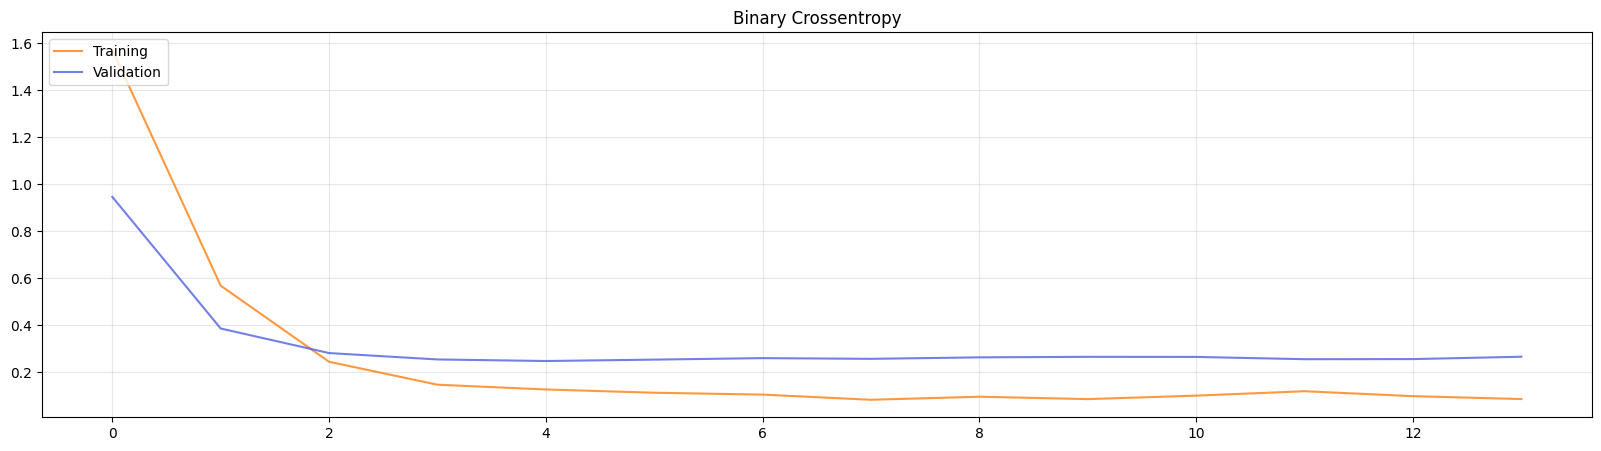

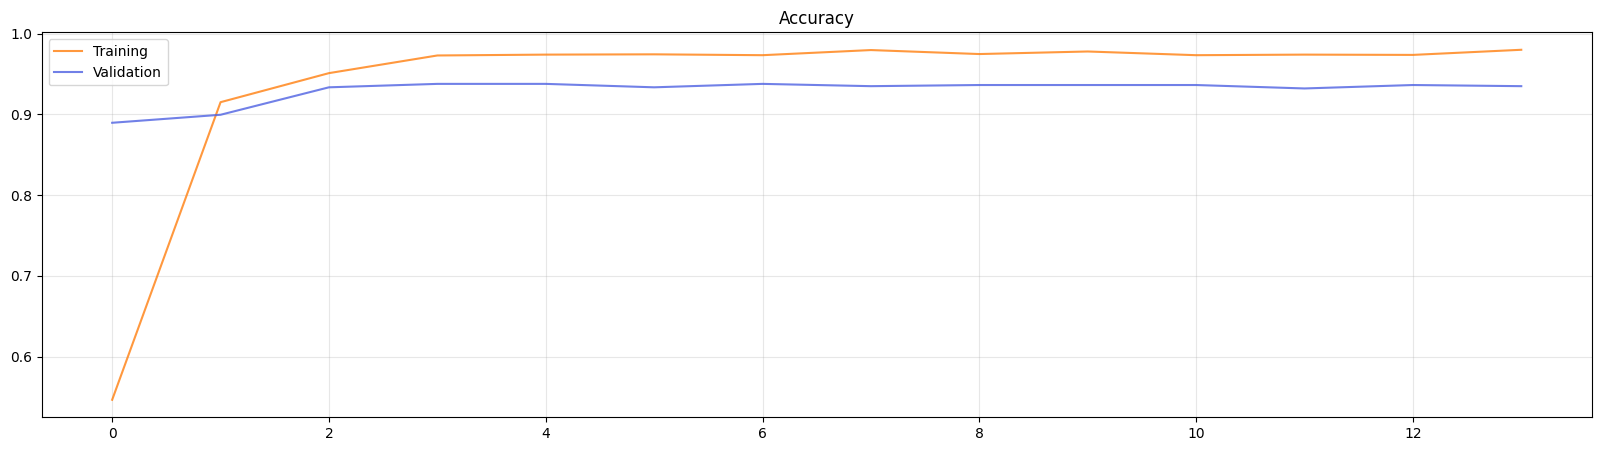

In [49]:
# Plot the training
plot_acc_loss(ens_history) 

### Performance

In [50]:
evaluate_classes_performance(ens_model, valid_gen)

23/23 [==============================] - 14s 244ms/step
              precision    recall  f1-score   support

           0       0.85      0.62      0.72        37
           1       0.91      0.96      0.94       106
           2       0.96      0.98      0.97       103
           3       0.94      0.96      0.95       102
           4       0.96      0.93      0.95       106
           5       1.00      0.82      0.90        44
           6       0.99      0.99      0.99       107
           7       0.87      0.96      0.91       101

    accuracy                           0.94       706
   macro avg       0.94      0.90      0.92       706
weighted avg       0.94      0.94      0.94       706



### Save

In [ ]:
ens_model.save('EnsembleModel')